Python implementations of 
- Principal component analysis
- Linear discriminant analysis
- Bayes classifier and
- k-Nearest Neighbors classifier 
Then application on the Olivetti faces dataset to 

Part I: identification of the subject label from a test image and 

Part II: neutral vs. facial expression classification

Can also be run using the files part_1.py & part_2.py which will load datasets ,illumination.mat and data.mat,respectively
do the experiments and printout the results,
 can be run from terminal with

python3 task_1.py/task_1.py

Or you can include any of the following files in a python code and call the functions within

- pca.py
- lda.py
- bayes.py
- knn.py

The functions follow similar libraries conventions
pca expects number of components and a Boolean for whitening
lda can be called with components too, but if None it will return the max # of discriminants (# classes - 1)
bays takes no argument to initialize and knn needs the number of neighbors

Because of the shuffle split for train and test accuracy may go up and down a little on every run,
to see the general trend please rerun them couple of times.


# Facial recognition on the Olivetti faces dataset

In [1]:
import numpy as np
import random
from scipy.io import loadmat
import matplotlib.pyplot as plt

In [2]:
# import implementations of PCA, LDA, BAYES and KNN 
from pca import *
from bayes import *
from knn import *
from lda import *

### Part 1
#### Identifying subject label

In [3]:
data_folder = './Data/' 
# Test Ratio
test_ratio = 0.2
# Random Seed
np.random.seed(13)
illum = loadmat(data_folder+'illumination.mat')['illum']
# Convert the dataset in data vectors and labels for subject identification
data = []
labels = []
for subject in range(illum.shape[2]):
    for image in range(illum.shape[1]):
        data.append(illum[:,image,subject])
        labels.append(subject)

# Split to train and test data        
N = int( (1-test_ratio)*len(data) )
idx = np.arange(len(data))
random.shuffle(idx)
tmp = np.asarray(data)
l =np.asarray(labels)
train_data = tmp[idx[:N]]
train_labels = l[idx[:N]]
test_data = tmp[idx[N:]]
test_labels = l[idx[N:]]

To see how many components we need to keep we need to figure out how much of the variance is explained by the components.
The Principal Components should explain at least 80% of the variance. To do that we calculate eigenvalues and their variance and do a scree plot. To make things easier the PCA function provides explained variance we can use to plot.

We call the PCA function with the number of components we need to keep and a boolean for whitening.Which can be useful in image classification where the input data is redundant because adjacent pixels are highly correlated. Whitening makes the features less correlated by projecting the dataset onto the eigenvectors and normalize the dataset by dividing each component by the square root of its eigenvalue. 
 

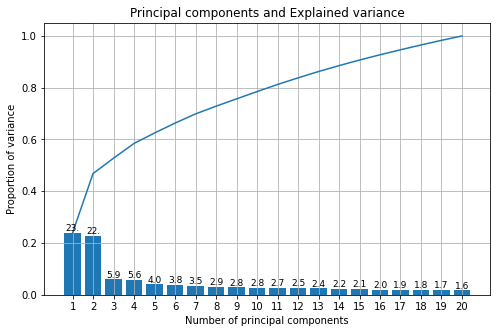

In [17]:
pca=PCA(20, False) # fit PCA with 20 components for plotting
pca.fit(tmp)
cum_var = [np.sum(pca.explained_variance[:i+1]) for i in range(len(pca.explained_variance))] 
x_labels = ['{}'.format(i+1) for i in range(len(pca.explained_variance))]
fig, ax = plt.subplots()
ax.set_xlabel('Number of principal components')
ax.set_ylabel('Proportion of variance')
ax.set_title('Principal components and Explained variance')
ax.grid()
fig.set_figwidth(8)
fig.set_figheight(5)
ax = plt.subplot()
ax.bar(x_labels,pca.explained_variance)
ax.plot(x_labels,cum_var)
for val in range(len(pca.explained_variance)):
    ax.annotate(r"%s" % ((str(pca.explained_variance[val]*100)[:3])), (x_labels[val],pca.explained_variance[val]), va = 'bottom',ha = 'center',fontsize =9)


As it can be seen above the first component explains about 23% of the variance, the first two 45%  and so on. If we keep the first 20 components we will retain 97.5% of the variance. Which is so much better than the original data in terms of dimensions.

We'll first do the classification with just Bayes and KNN classifiers to see how much better they would do on their own vs with PCA and LDA.   

In [62]:
# Accuracy function that'll be used throughout 
def accuracy(y_true, y_pred):
    accuracy = np.sum(y_true == y_pred) / len(y_true)
    return accuracy*100

In [8]:

X_train, X_test, y_train, y_test = train_data,test_data,train_labels,test_labels

# KNN
k = 4
clf = KNN(k)
clf.fit(train_data, train_labels)
predictions = clf.predict(test_data)
print("KNN classification accuracy", accuracy(test_labels, predictions))
# bayes
nb = BAYES()
nb.fit(X_train, y_train)
predictions = nb.predict(X_test)
print("Naive Bayes classification accuracy", accuracy(y_test, predictions))

KNN classification accuracy 81.46853146853147
Naive Bayes classification accuracy 49.3006993006993


The KNN classifier seems to do ok on its own and Bayes classifier does a little bit worse than guessing. Now lets actually apply PCA to our data and rerun the classification.
From trial and error I've found out the classifiers do best with number of principal components equal to 35. 

In [15]:
n_components = 35
pca=PCA(n_components, whiten=True)
pca.fit(train_data)
X_train_pca=pca.transform(train_data)
#pca.fit(test_data)
X_test_pca=pca.transform(test_data)

In [18]:
# KNN
k = 4
clf = KNN(k)
clf.fit(X_train_pca, train_labels)
predictions = clf.predict(X_test_pca)
print("KNN with PCA classification accuracy", accuracy(test_labels, predictions))

# Bayes
nb = BAYES()
nb.fit(X_train_pca, train_labels)
predictions = nb.predict(X_test_pca)
print("Naive Bayes with PCA classification accuracy", accuracy(test_labels, predictions))


KNN with PCA classification accuracy 89.5104895104895
Naive Bayes with PCA classification accuracy 74.82517482517483


KNN had an accuracy gain of almost 10% and Bayes about 25%, with PCA compared to without. I tried running the experiments with just 20 components, since it explains 97.5% of the variance, but 35 components was better. It seems like the last 2-3% of variance really helps fine tune the prediction.

We will next move onto doing Linear discriminant analysis, which unlike PCA is a supervised dimensionality reduction technique. While PCA doesn't require any class information LDA needs class labels to maximize class separability.   

When I applied LDA on itself on the original dataset I kept getting an error because SW was a singular matrix and thus invertible. I tried adding an identity matrix of the same size multiplied by a small constant, 1e-9, but still got overflow errors in the bayes classifier. Which was apparently dividing by a very small number while calculating pdf. The solution I found was to do PCA on the original data first and then LDA, and again from trial and error PCA with 35 components followed by LDA with 11 components yielded the best results.  

In [19]:
lda = LDA(11)
lda.fit(X_train_pca, train_labels)
X_projected = lda.transform(X_train_pca)
#lda.fit(X_test_pca, test_labels)
X_test_projected = lda.transform(X_test_pca)
k = 4
clf = KNN(k)
clf.fit(X_projected, train_labels)
predictions = clf.predict(X_test_projected)
print("KNN with PCA & LDA classification accuracy", accuracy(test_labels, predictions))
n =  BAYES()
n.fit(X_projected, train_labels)
predictions = n.predict(X_test_projected)
print("Naive Bayes with PCA & LDA classification accuracy", accuracy(test_labels, predictions))


KNN with PCA & LDA classification accuracy 91.25874125874127
Naive Bayes with PCA & LDA classification accuracy 83.56643356643356


As it can be seen above KNN with PCA and LDA got 91% of its predictions right, and Bayes 83% which is much better than 49% earlier. A little note here because the dataset is split based on a random shuffle the accuracy percentages go up and down a little every time I reran the experiment with a different shuffle. 
The best performance over all was KNN with PCA and LDA, 94.4% and Bayes with PCA and LDA 89%.

## Part 2 
### Neutral vs. Facial expression classification

In [25]:
# Load data.mat
Ns = 200 
face = loadmat(data_folder+'data.mat')['face']
face_n = [face[:,:,3*n] for n in range(Ns)] # neutral
face_x = [face[:,:,3*n+1] for n in range(Ns)] # expression
face_il = [face[:,:,3*n+2] for n in range(Ns)] # illumination variation
data = []
labels = []
for subject in range(Ns):  
    data.append(face_n[subject].reshape(-1))
    labels.append(0)
    data.append(face_x[subject].reshape(-1))
    labels.append(1)
# Split to train and test data        
N = int( (1-test_ratio)*len(data) )
idx = np.arange(len(data))
random.shuffle(idx)
tmp = np.asarray(data)
l =np.asarray(labels)
train_data = tmp[idx[:N]]
train_labels = l[idx[:N]]
test_data = tmp[idx[N:]]
test_labels = l[idx[N:]]

X_train, X_test, y_train, y_test = train_data,test_data,train_labels,test_labels

Just like we did above let's first do a scree plot to see the explained variance. 

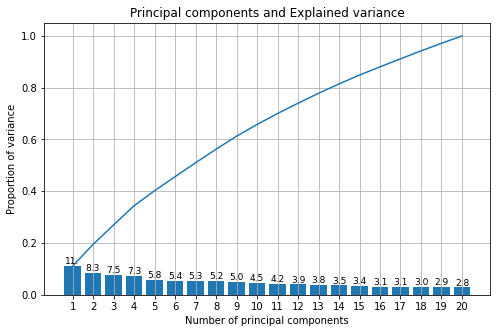

In [26]:
pca=PCA(20, False)
pca.fit(tmp)

cum_var = [np.sum(pca.explained_variance[:i+1]) for i in range(len(pca.explained_variance))] 
x_labels = ['{}'.format(i+1) for i in range(len(pca.explained_variance))]
fig, ax = plt.subplots()
ax.set_xlabel('Number of principal components')
ax.set_ylabel('Proportion of variance')
ax.set_title('Principal components and Explained variance')
ax.grid()
fig.set_figwidth(8)
fig.set_figheight(5)
ax = plt.subplot()
ax.bar(x_labels,pca.explained_variance)
ax.plot(x_labels,cum_var)
for val in range(len(pca.explained_variance)):
    ax.annotate(r"%s" % ((str(pca.explained_variance[val]*100)[:3])), (x_labels[val],pca.explained_variance[val]), va = 'bottom',ha = 'center',fontsize =9)


It looks like the first principal component explains only 11% of the variance and we might need to keep more components. Let's first get a baseline for performance by running the classifiers without PCA and LDA. 

In [47]:
# Bayes
nb = BAYES()
nb.fit(X_train, y_train)
predictions = nb.predict(X_test)
print("Naive Bayes classification accuracy", accuracy(y_test, predictions))
# KNN
k = 4
clf = KNN(k=k)
clf.fit(X_train, y_train)
predictions = clf.predict(X_test)
print("KNN classification accuracy", accuracy(y_test, predictions))

Naive Bayes classification accuracy 56.25
KNN classification accuracy 75.0


They bayes classifier by itself does a little better than chance and KNN gets it right 3/4 of the time. Let's see what doing PCA and LDA will result in. 

In [48]:
n_components = 11
pca=PCA(n_components, whiten=False)
pca.fit(train_data)
X_train_pca=pca.transform(train_data)
#pca.fit(test_data)
X_test_pca=pca.transform(test_data)
nb =BAYES()
nb.fit(X_train_pca, train_labels)
predictions = nb.predict(X_test_pca)
print("Naive Bayes with PCA classification accuracy", accuracy(test_labels, predictions))
k = 4   
clf = KNN(k=k)
clf.fit(X_train_pca, train_labels)
predictions = clf.predict(X_test_pca)
print("KNN with PCA classification accuracy", accuracy(test_labels, predictions))

Naive Bayes with PCA classification accuracy 76.25
KNN with PCA classification accuracy 86.25


Bayes seems to do about 20% better with PCA and KNN with 4 neighbors about 10% better. I rerun the above experiment couple of times and 11 components got the best accuracy for PCA and later when LDA was done on it.

Another note here I used the cell below to filter a complex casting error message  Bayes kept running into   while calculating mean after LDA is performed on the data. It seemed benign and didn't affect the accuracy, and it only comes up in this particular case.    

In [38]:
import warnings
warnings.filterwarnings("ignore", message="Casting complex values to real discards the imaginary part")

In [49]:
lda = LDA(2)
lda.fit(X_train_pca, train_labels)
X_projected = lda.transform(X_train_pca)
#lda.fit(X_test_pca, test_labels)
X_test_projected = lda.transform(X_test_pca)
nb = BAYES()
nb.fit(X_projected, train_labels)
predictions = nb.predict(X_test_projected)
print("Naive Bayes with LDA classification accuracy", accuracy(test_labels, predictions))
k = 3
clf = KNN(k=k)
clf.fit(X_projected, train_labels)
predictions = clf.predict(X_test_projected)
print("KNN with LDA classification accuracy", accuracy(test_labels, predictions))

Naive Bayes with LDA classification accuracy 91.25
KNN with LDA classification accuracy 90.0


Our baseline was 85% and 77.5% for Bayes and KNN, respectively, just by themselves. So as it can be seen above Bayes got up to 91.25% with PCA and LDA and KNN,k=4, had about 5% boost. Which is quite decent. Again the accuracy goes up and down a little based on the split shuffle but the general trend seems to be both Bayes and KNN get progressively better with just PCA and then with PCA and LDA. I also played with the nearest neighbors value and generally,throughout this whole experiment,k=4 seemed to give a good accuracy and k=3 in this particular experiment. 
Last note here, finding the right parameters was the most challenging part of this experiment. The coding part took relatively less time but fine tuning the parameters at times felt like an art I need to work at.    